In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import sys

# Add src to path
sys.path.append("src")
from BWImage import BWImage
from GeometricTransforms import rotate_translate

## Jupyter notebooks settings.

# Reload modules before executing each cell.
%load_ext autoreload
%autoreload 2 

# Print all print statements.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# Set white as color for pixels with no value.
BWImage.blank_value = 255 

# Introduction

In this lab we are given two images `IMG1.png` and `IMG2.png` and two point correspondences between them. 
* The input images and the point correspondence information are stored in the `data\input` folder.
* First we solve the point correspondences to get the geometric transformation. 

* Following this we, transform IMG2 and take the difference between IMG2 and IMG to reveal the difference between these two images.

#### Implementations
* `BWImage` class is the same from lab-1 and it contains the code for storing an image as numpy array and associated methods. In particular, it contains the method for bilinear interpolation.
* `GeometricTransforms.py` Contains one function `rotate_transform` that takes as input the source image, target image and rotation and translation matrices and performs the geometric transformation.

#### Output
* IMG1, transformed IMG2, the raw difference between IMG1 and IMG2 and the difference with a threshold are plotted.
* This plot is also stored in `data\output` folder.


# 1. Solve the point correspondences

We are given two images IMG1 and IMG2. They are related by in-plane translation and rotation.
Let $(x^1_i, y^1_i)$ represent point-$i$ from IMG1 and $(x^2_i, y^2_i)$ represent the corresponding point from IMG2. Given that they are related by in-plane rotation and translation we can assume that they are related by the following equation.



$$
\begin{bmatrix}
x^1_i\\
y^1_i
\end{bmatrix}
=
\begin{bmatrix}
a & -b\\
b & a
\end{bmatrix}

\begin{bmatrix}
x^2_i\\
y^2_i
\end{bmatrix}

+

\begin{bmatrix}
t_x\\
t_y
\end{bmatrix}
$$

We are given two point correspondences, $(x^1_1, y^1_1) \to (x^2_1, y^2_1)$ and $(x^1_2, y^1_2)\to (x^2_2, y^2_2)$

We could write this as:

$$
\begin{bmatrix}
x^2_1 & -y^2_1 & 1 & 0\\
y^2_1 & x^2_1 & 0 & 1\\
x^2_2 & -y^2_2 & 1 & 0\\
y^2_2 & x^2_2 & 0 & 1\\
\end{bmatrix}

\begin{bmatrix}
a\\
b\\
t_x\\
t_y
\end{bmatrix}

= 

\begin{bmatrix}
x^1_1\\ 
y^1_1\\ 
x^1_2\\ 
y^1_2 
\end{bmatrix}

$$

We can look at it as $Ma = z$ and get $x$ by $a = M^{-1}z$.

In [2]:
## Read point correspondences.
data = np.genfromtxt('data/input/pt_correspondences.csv', delimiter=',')
# pi_j represents j-th point from IMG-i.
# Eg: p1_2 is (x^1_2, y^1_2)
p1_1 = data[0][0:2]
p2_1 = data[0][2:4]
p1_2 = data[1][0:2] 
p2_2 = data[1][2:4]

In [3]:
## Solve the point correspondences.
# Ma = z

M = np.zeros((4, 4))
M[0] = np.array([p2_1[0], -1 * p2_1[1], 1, 0]) 
M[1] = np.array([p2_1[1], p2_1[0], 0, 1]) 
M[2] = np.array([p2_2[0], -1 * p2_2[1], 1, 0]) 
M[3] = np.array([p2_2[1], p2_2[0], 0, 1]) 

z = np.array([p1_1[0], p1_1[1], p1_2[0], p1_2[1]])

# Solve for a. a = M^{-1}z.
a = np.linalg.inv(M) @ z

# Obtain R and T (rotation & translation matrices, respectively)
# from a.
R = np.array([[a[0], -1 * a[1]], [a[1], a[0]]])
T = np.array([a[2], a[3]])
T = T.reshape(2, 1)

In [4]:
# Print the geometric transformation.
print("Rotation matrix:")
print("================")
print(R)
print("Translation vector:")
print("===================")
print(T)

Rotation matrix:
[[ 0.8654551  -0.49921821]
 [ 0.49921821  0.8654551 ]]
Translation vector:
[[  72.31879117]
 [-137.06015943]]


From the above output we can see that $\cos\theta = 0.8654551$ and $\sin\theta = 0.49921821$. From this we get that $\theta = 30^{\circ}$.

Therefore, IMG1 can be obtained from IMG2 by first rotating IMG2 anti-clockwise by $30^{\circ}$ followed by applying the translation $[72.31, -137.06]^T$.

# 2. Apply the geometric tranformation.

/tmp/ipykernel_7747/2145615690.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


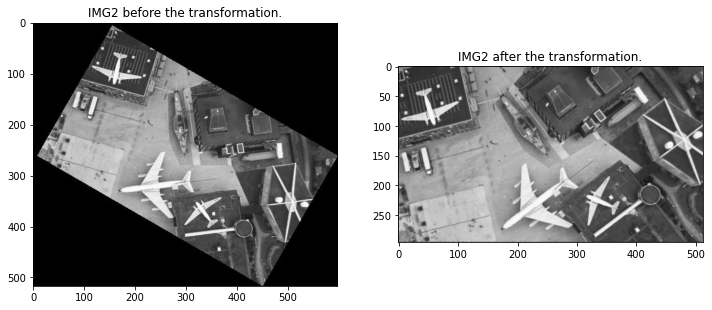

In [5]:
# Read the input images.

img1 = cv2.imread('data/input/IMG1.png')
img2 = cv2.imread('data/input/IMG2.png')

# Rotate source image
target = BWImage()
target.make_blank(img1.shape)
source = BWImage(img2)
rotate_translate(source, target, R, T)

# Copy the image form target (an object of the BWImage class)
# to a simple numpy array.
img2_transformed = target.get_image()

## Print IMG2 post-transformation.
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(img2);
ax[0].set_title("IMG2 before the transformation.");
ax[1].imshow(img2_transformed);
ax[1].set_title("IMG2 after the transformation.");
fig.savefig('data/output/img2_before_after_transform.png');
fig.show();

# 3. Get the difference and show the images.

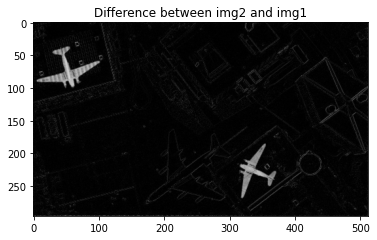

In [6]:
## Get the diffrence between img1 and img2_transformed.
img_diff = np.abs(img2_transformed - img1) 

plt.imshow(img_diff);
plt.title("Difference between img2 and img1");
plt.savefig("data/output/raw_diff.png", facecolor='white');
plt.show();

The above image is the raw absolute difference between IMG1 and transformed IMG2. 
The image exhibits some artifacts of weak intensity lines.

Next we use a threshold to remove these weak artifacts. To determine the thresholds I plotted histogram of the pixel intensities where the y-axis is of log scale.

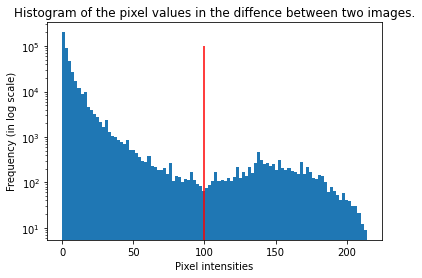

In [7]:
# Plot the histogram of difference.
plt.hist((np.abs(target.get_image() - img1).flatten()), bins=100);
plt.yscale('log');
plt.title('Histogram of the pixel values in the diffence between two images.');
plt.xlabel('Pixel intensities');
plt.ylabel('Frequency (in log scale)');
plt.vlines(100, ymin= 0, ymax=1e5, colors='red');

However, this does not seem to give very useful threshold, because while 100 looks like a good threshold because of a minima there, using 100 as a threshold gives a very weak image as output as shown below.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


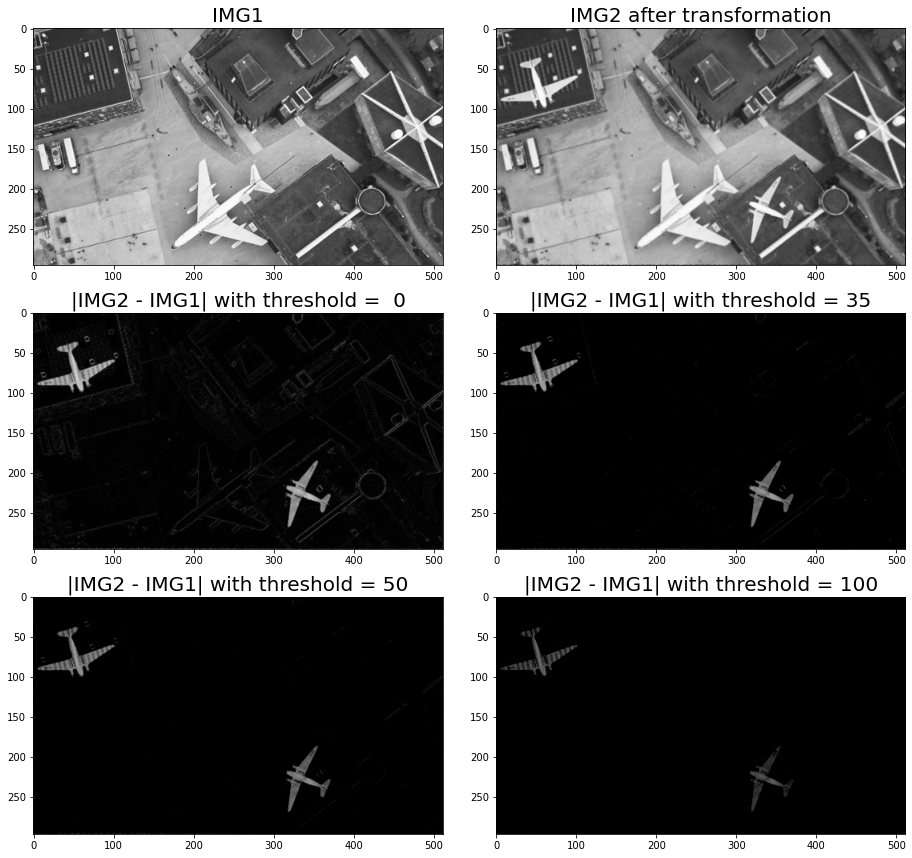

In [8]:
threshold = [35, 50, 100]
fig, ax = plt.subplots(3, 2, figsize=(13, 12))
ax[0, 0].imshow(img1);
ax[0, 1].imshow(target.get_image());
ax[1, 0].imshow(np.abs(target.get_image() - img1));
ax[2, 1].imshow(np.abs(target.get_image() - img1) - threshold[2]);
ax[2, 0].imshow(np.abs(target.get_image() - img1) - threshold[1]);
ax[1, 1].imshow(np.abs(target.get_image() - img1) - threshold[0]);

ax[0, 0].set_title("IMG1", fontsize=20);
ax[0, 1].set_title("IMG2 after transformation", fontsize=20);
ax[1, 0].set_title("|IMG2 - IMG1| with threshold =  0", fontsize=20);
ax[2, 1].set_title("|IMG2 - IMG1| with threshold = " + str(threshold[2]), fontsize=20);
ax[2, 0].set_title("|IMG2 - IMG1| with threshold = " + str(threshold[1]), fontsize=20);
ax[1, 1].set_title("|IMG2 - IMG1| with threshold = " + str(threshold[0]), fontsize=20);
fig.tight_layout();
fig.savefig('data/output/out.png', facecolor='white');

# Conclusion

There are two new aircrafts in the top-left and bottom-right parts of IMG2.
By, trial and error, it looks like a threshold of 35 works well. We recover the new objects with good intensity and also avoid most of the artifacts.